In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [4]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [5]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [6]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    rates = tf.reshape(rates, shape=[-1, 1])
    gloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                   labels=rates)) # 0-1
#     targetQs = tf.reshape(targetQs, shape=[-1, 1])
#     gloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
#                                                                     labels=tf.nn.sigmoid(targetQs))) # 0-1
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    dlossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=rates)) # 0-1
#     dlossA += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
#                                                                      labels=tf.nn.sigmoid(targetQs))) # 0-1
    dlossA += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                     labels=tf.zeros_like(rates))) # 0-1
    dlossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ += tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    return actions_logits, gQs, gloss, dlossA, dlossQ

In [7]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_lossA, d_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_optA = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossA, var_list=d_vars)
        d_optQ = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossQ, var_list=d_vars)

    return g_opt, d_optA, d_optQ

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_lossA, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_optA, self.d_optQ = model_opt(g_loss=self.g_loss, 
                                                         d_lossA=self.d_lossA, 
                                                         d_lossQ=self.d_lossQ, 
                                                         g_learning_rate=g_learning_rate, 
                                                         d_learning_rate=d_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list = [] # goal
rewards_list, gloss_list, dloss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*3):
        total_reward = 0 # each episode
        gloss_batch, dlossA_batch, dlossQ_batch= [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode
        idx_arr = np.arange(memory_size// batch_size)

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
                #print(action)
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits) # adding epsilon*noise
                #print(action)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            dlossA, dlossQ, _ = sess.run([model.d_lossA, model.d_lossQ, model.d_optA], #, model.d_optQ
                                         feed_dict = {model.states: states, 
                                                      model.actions: actions,
                                                      model.targetQs: targetQs, 
                                                      model.rates: rates})
            gloss, _ = sess.run([model.g_loss, model.g_opt], #, model.d_optQ
                                feed_dict = {model.states: states, 
                                             model.actions: actions,
                                             model.targetQs: targetQs, 
                                             model.rates: rates})
            gloss_batch.append(gloss)
            dlossA_batch.append(dlossA)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dlossA:{:.4f}'.format(np.mean(dlossA_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        #gloss_list.append([ep, np.mean(gloss_batch)])
        #dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:20.0000 R:20.0000 rate:0.0400 gloss:0.7354 dlossA:1.5531 dlossQ:1.7555 exploreP:0.9980
Episode:1 meanR:21.0000 R:22.0000 rate:0.0440 gloss:0.7251 dlossA:1.5318 dlossQ:1.7445 exploreP:0.9959
Episode:2 meanR:18.0000 R:12.0000 rate:0.0240 gloss:0.7208 dlossA:1.5190 dlossQ:1.7504 exploreP:0.9947
Episode:3 meanR:17.0000 R:14.0000 rate:0.0280 gloss:0.7191 dlossA:1.5181 dlossQ:1.7440 exploreP:0.9933
Episode:4 meanR:16.0000 R:12.0000 rate:0.0240 gloss:0.7080 dlossA:1.4902 dlossQ:1.7396 exploreP:0.9921
Episode:5 meanR:15.8333 R:15.0000 rate:0.0300 gloss:0.7038 dlossA:1.4839 dlossQ:1.7311 exploreP:0.9906
Episode:6 meanR:17.7143 R:29.0000 rate:0.0580 gloss:0.6952 dlossA:1.4600 dlossQ:1.7399 exploreP:0.9878
Episode:7 meanR:17.6250 R:17.0000 rate:0.0340 gloss:0.6909 dlossA:1.4485 dlossQ:1.7493 exploreP:0.9861
Episode:8 meanR:17.6667 R:18.0000 rate:0.0360 gloss:0.6901 dlossA:1.4419 dlossQ:1.7633 exploreP:0.9844
Episode:9 meanR:18.2000 R:23.0000 rate:0.0460 gloss:0.6788 dlossA:1.4215 

Episode:79 meanR:20.9500 R:15.0000 rate:0.0300 gloss:0.4015 dlossA:0.6146 dlossQ:1.5836 exploreP:0.8472
Episode:80 meanR:20.8889 R:16.0000 rate:0.0320 gloss:0.4109 dlossA:0.6088 dlossQ:1.6579 exploreP:0.8459
Episode:81 meanR:20.9390 R:25.0000 rate:0.0500 gloss:0.4070 dlossA:0.6089 dlossQ:1.6227 exploreP:0.8438
Episode:82 meanR:20.8916 R:17.0000 rate:0.0340 gloss:0.4012 dlossA:0.6022 dlossQ:1.7827 exploreP:0.8424
Episode:83 meanR:20.7857 R:12.0000 rate:0.0240 gloss:0.4188 dlossA:0.6118 dlossQ:1.5892 exploreP:0.8414
Episode:84 meanR:20.7529 R:18.0000 rate:0.0360 gloss:0.3777 dlossA:0.6016 dlossQ:1.5624 exploreP:0.8399
Episode:85 meanR:20.7209 R:18.0000 rate:0.0360 gloss:0.3768 dlossA:0.5910 dlossQ:1.6345 exploreP:0.8384
Episode:86 meanR:20.6322 R:13.0000 rate:0.0260 gloss:0.3947 dlossA:0.5984 dlossQ:1.6128 exploreP:0.8373
Episode:87 meanR:20.6818 R:25.0000 rate:0.0500 gloss:0.3887 dlossA:0.5977 dlossQ:1.6067 exploreP:0.8353
Episode:88 meanR:20.6180 R:15.0000 rate:0.0300 gloss:0.3798 dlos

Episode:158 meanR:19.3900 R:24.0000 rate:0.0480 gloss:0.4031 dlossA:0.5396 dlossQ:2.6193 exploreP:0.7339
Episode:159 meanR:19.2600 R:14.0000 rate:0.0280 gloss:0.3905 dlossA:0.5378 dlossQ:2.4646 exploreP:0.7329
Episode:160 meanR:19.2400 R:18.0000 rate:0.0360 gloss:0.3752 dlossA:0.5279 dlossQ:2.4722 exploreP:0.7316
Episode:161 meanR:19.2300 R:11.0000 rate:0.0220 gloss:0.3802 dlossA:0.5257 dlossQ:2.5667 exploreP:0.7308
Episode:162 meanR:19.0000 R:17.0000 rate:0.0340 gloss:0.3454 dlossA:0.4951 dlossQ:2.6730 exploreP:0.7295
Episode:163 meanR:19.0500 R:20.0000 rate:0.0400 gloss:0.4081 dlossA:0.5468 dlossQ:2.7265 exploreP:0.7281
Episode:164 meanR:18.9200 R:20.0000 rate:0.0400 gloss:0.3815 dlossA:0.5286 dlossQ:2.6939 exploreP:0.7267
Episode:165 meanR:18.9200 R:14.0000 rate:0.0280 gloss:0.3683 dlossA:0.5160 dlossQ:2.6439 exploreP:0.7257
Episode:166 meanR:18.8500 R:12.0000 rate:0.0240 gloss:0.4116 dlossA:0.5515 dlossQ:2.6837 exploreP:0.7248
Episode:167 meanR:18.9900 R:31.0000 rate:0.0620 gloss:0

Episode:237 meanR:21.7000 R:15.0000 rate:0.0300 gloss:0.4014 dlossA:0.5412 dlossQ:4.4667 exploreP:0.6158
Episode:238 meanR:21.8000 R:22.0000 rate:0.0440 gloss:0.3866 dlossA:0.5312 dlossQ:4.4383 exploreP:0.6145
Episode:239 meanR:21.8400 R:16.0000 rate:0.0320 gloss:0.4255 dlossA:0.5744 dlossQ:4.5545 exploreP:0.6135
Episode:240 meanR:21.8600 R:14.0000 rate:0.0280 gloss:0.4111 dlossA:0.5556 dlossQ:4.4593 exploreP:0.6127
Episode:241 meanR:21.7600 R:9.0000 rate:0.0180 gloss:0.3758 dlossA:0.5212 dlossQ:4.5458 exploreP:0.6121
Episode:242 meanR:21.7800 R:13.0000 rate:0.0260 gloss:0.4147 dlossA:0.5614 dlossQ:4.6558 exploreP:0.6114
Episode:243 meanR:21.5900 R:10.0000 rate:0.0200 gloss:0.4103 dlossA:0.5530 dlossQ:4.5569 exploreP:0.6108
Episode:244 meanR:21.4700 R:12.0000 rate:0.0240 gloss:0.4126 dlossA:0.5667 dlossQ:4.5572 exploreP:0.6100
Episode:245 meanR:21.5500 R:22.0000 rate:0.0440 gloss:0.3815 dlossA:0.5195 dlossQ:4.4425 exploreP:0.6087
Episode:246 meanR:21.3600 R:22.0000 rate:0.0440 gloss:0.

Episode:316 meanR:16.5300 R:16.0000 rate:0.0320 gloss:0.3976 dlossA:0.4846 dlossQ:2.9695 exploreP:0.5425
Episode:317 meanR:16.4300 R:12.0000 rate:0.0240 gloss:0.3664 dlossA:0.4499 dlossQ:3.0318 exploreP:0.5418
Episode:318 meanR:16.4200 R:18.0000 rate:0.0360 gloss:0.4139 dlossA:0.5011 dlossQ:2.9218 exploreP:0.5409
Episode:319 meanR:16.2700 R:14.0000 rate:0.0280 gloss:0.4194 dlossA:0.4931 dlossQ:2.9054 exploreP:0.5401
Episode:320 meanR:16.2300 R:8.0000 rate:0.0160 gloss:0.4803 dlossA:0.5561 dlossQ:2.8366 exploreP:0.5397
Episode:321 meanR:16.2100 R:10.0000 rate:0.0200 gloss:0.4046 dlossA:0.4852 dlossQ:2.9695 exploreP:0.5392
Episode:322 meanR:16.1800 R:9.0000 rate:0.0180 gloss:0.4255 dlossA:0.4978 dlossQ:2.7816 exploreP:0.5387
Episode:323 meanR:16.1700 R:10.0000 rate:0.0200 gloss:0.5289 dlossA:0.6334 dlossQ:3.2201 exploreP:0.5382
Episode:324 meanR:16.1700 R:13.0000 rate:0.0260 gloss:0.4243 dlossA:0.5104 dlossQ:2.9782 exploreP:0.5375
Episode:325 meanR:16.1800 R:10.0000 rate:0.0200 gloss:0.4

Episode:395 meanR:14.1800 R:33.0000 rate:0.0660 gloss:0.4298 dlossA:0.4433 dlossQ:2.0966 exploreP:0.4876
Episode:396 meanR:14.1900 R:11.0000 rate:0.0220 gloss:0.4351 dlossA:0.4463 dlossQ:2.0490 exploreP:0.4871
Episode:397 meanR:14.2400 R:13.0000 rate:0.0260 gloss:0.4482 dlossA:0.4623 dlossQ:2.1998 exploreP:0.4865
Episode:398 meanR:14.2400 R:13.0000 rate:0.0260 gloss:0.4491 dlossA:0.4540 dlossQ:4.1404 exploreP:0.4859
Episode:399 meanR:14.2600 R:18.0000 rate:0.0360 gloss:0.4026 dlossA:0.4276 dlossQ:2.0241 exploreP:0.4850
Episode:400 meanR:14.2200 R:8.0000 rate:0.0160 gloss:0.4716 dlossA:0.4645 dlossQ:2.2326 exploreP:0.4846
Episode:401 meanR:14.2100 R:16.0000 rate:0.0320 gloss:0.4307 dlossA:0.4447 dlossQ:2.0553 exploreP:0.4839
Episode:402 meanR:14.2500 R:18.0000 rate:0.0360 gloss:0.4222 dlossA:0.4363 dlossQ:2.0710 exploreP:0.4830
Episode:403 meanR:14.1800 R:12.0000 rate:0.0240 gloss:0.3996 dlossA:0.4243 dlossQ:2.0326 exploreP:0.4824
Episode:404 meanR:14.1800 R:11.0000 rate:0.0220 gloss:0.

Episode:474 meanR:16.2800 R:14.0000 rate:0.0280 gloss:0.3909 dlossA:0.4744 dlossQ:3.0623 exploreP:0.4289
Episode:475 meanR:16.1500 R:9.0000 rate:0.0180 gloss:0.3930 dlossA:0.4719 dlossQ:3.0899 exploreP:0.4286
Episode:476 meanR:16.0900 R:11.0000 rate:0.0220 gloss:0.4066 dlossA:0.4870 dlossQ:3.0012 exploreP:0.4281
Episode:477 meanR:16.0200 R:9.0000 rate:0.0180 gloss:0.4187 dlossA:0.4954 dlossQ:2.9909 exploreP:0.4277
Episode:478 meanR:15.9800 R:11.0000 rate:0.0220 gloss:0.3951 dlossA:0.4700 dlossQ:3.1605 exploreP:0.4273
Episode:479 meanR:15.8200 R:14.0000 rate:0.0280 gloss:0.4921 dlossA:0.5703 dlossQ:2.9782 exploreP:0.4267
Episode:480 meanR:15.7800 R:9.0000 rate:0.0180 gloss:0.4185 dlossA:0.5033 dlossQ:3.1196 exploreP:0.4263
Episode:481 meanR:15.7800 R:11.0000 rate:0.0220 gloss:0.3729 dlossA:0.4518 dlossQ:3.0094 exploreP:0.4258
Episode:482 meanR:15.7100 R:12.0000 rate:0.0240 gloss:0.4452 dlossA:0.5283 dlossQ:3.2370 exploreP:0.4253
Episode:483 meanR:15.7100 R:9.0000 rate:0.0180 gloss:0.427

Episode:553 meanR:12.7100 R:11.0000 rate:0.0220 gloss:0.5051 dlossA:0.5271 dlossQ:2.2058 exploreP:0.3891
Episode:554 meanR:12.7400 R:17.0000 rate:0.0340 gloss:0.3984 dlossA:0.4293 dlossQ:2.3572 exploreP:0.3885
Episode:555 meanR:12.7500 R:12.0000 rate:0.0240 gloss:0.4400 dlossA:0.4657 dlossQ:2.2410 exploreP:0.3880
Episode:556 meanR:12.6300 R:11.0000 rate:0.0220 gloss:0.4674 dlossA:0.4927 dlossQ:2.3609 exploreP:0.3876
Episode:557 meanR:12.6100 R:12.0000 rate:0.0240 gloss:0.4107 dlossA:0.4380 dlossQ:2.2754 exploreP:0.3872
Episode:558 meanR:12.6100 R:11.0000 rate:0.0220 gloss:0.4332 dlossA:0.4597 dlossQ:2.2155 exploreP:0.3868
Episode:559 meanR:12.6000 R:13.0000 rate:0.0260 gloss:0.4793 dlossA:0.4981 dlossQ:2.2495 exploreP:0.3863
Episode:560 meanR:12.6200 R:14.0000 rate:0.0280 gloss:0.4492 dlossA:0.4743 dlossQ:2.2298 exploreP:0.3857
Episode:561 meanR:12.7000 R:18.0000 rate:0.0360 gloss:0.4562 dlossA:0.4814 dlossQ:2.3364 exploreP:0.3851
Episode:562 meanR:12.7500 R:13.0000 rate:0.0260 gloss:0

Episode:632 meanR:12.7200 R:8.0000 rate:0.0160 gloss:0.4625 dlossA:0.5463 dlossQ:2.7240 exploreP:0.3535
Episode:633 meanR:12.6800 R:8.0000 rate:0.0160 gloss:0.4699 dlossA:0.5512 dlossQ:2.7462 exploreP:0.3533
Episode:634 meanR:12.6800 R:12.0000 rate:0.0240 gloss:0.3564 dlossA:0.4337 dlossQ:2.8223 exploreP:0.3529
Episode:635 meanR:12.6200 R:13.0000 rate:0.0260 gloss:0.4334 dlossA:0.5174 dlossQ:2.7978 exploreP:0.3524
Episode:636 meanR:12.6100 R:12.0000 rate:0.0240 gloss:0.4208 dlossA:0.5061 dlossQ:2.7881 exploreP:0.3520
Episode:637 meanR:12.7200 R:20.0000 rate:0.0400 gloss:0.3950 dlossA:0.4783 dlossQ:2.8422 exploreP:0.3513
Episode:638 meanR:12.7500 R:12.0000 rate:0.0240 gloss:0.3945 dlossA:0.4795 dlossQ:2.8476 exploreP:0.3509
Episode:639 meanR:12.6600 R:9.0000 rate:0.0180 gloss:0.4354 dlossA:0.5188 dlossQ:2.7938 exploreP:0.3506
Episode:640 meanR:12.6400 R:15.0000 rate:0.0300 gloss:0.4111 dlossA:0.4941 dlossQ:2.9077 exploreP:0.3501
Episode:641 meanR:12.6300 R:12.0000 rate:0.0240 gloss:0.36

Episode:711 meanR:12.4700 R:13.0000 rate:0.0260 gloss:0.4328 dlossA:0.4896 dlossQ:2.3448 exploreP:0.3204
Episode:712 meanR:12.4800 R:11.0000 rate:0.0220 gloss:0.4088 dlossA:0.4660 dlossQ:2.2479 exploreP:0.3201
Episode:713 meanR:12.4600 R:10.0000 rate:0.0200 gloss:0.4322 dlossA:0.4852 dlossQ:2.2556 exploreP:0.3198
Episode:714 meanR:12.4300 R:10.0000 rate:0.0200 gloss:0.4161 dlossA:0.4733 dlossQ:2.2822 exploreP:0.3195
Episode:715 meanR:12.3900 R:9.0000 rate:0.0180 gloss:0.5018 dlossA:0.5524 dlossQ:2.1869 exploreP:0.3192
Episode:716 meanR:12.3800 R:12.0000 rate:0.0240 gloss:0.3932 dlossA:0.4516 dlossQ:2.2744 exploreP:0.3188
Episode:717 meanR:12.4200 R:16.0000 rate:0.0320 gloss:0.3744 dlossA:0.4334 dlossQ:2.3084 exploreP:0.3183
Episode:718 meanR:12.4200 R:10.0000 rate:0.0200 gloss:0.3828 dlossA:0.4418 dlossQ:2.3275 exploreP:0.3180
Episode:719 meanR:12.3900 R:9.0000 rate:0.0180 gloss:0.3617 dlossA:0.4207 dlossQ:2.3970 exploreP:0.3177
Episode:720 meanR:12.3700 R:9.0000 rate:0.0180 gloss:0.40

Episode:790 meanR:12.1000 R:12.0000 rate:0.0240 gloss:0.4002 dlossA:0.4678 dlossQ:2.9900 exploreP:0.2939
Episode:791 meanR:12.0700 R:10.0000 rate:0.0200 gloss:0.4312 dlossA:0.4986 dlossQ:2.6265 exploreP:0.2936
Episode:792 meanR:12.0700 R:12.0000 rate:0.0240 gloss:0.4040 dlossA:0.4685 dlossQ:2.6352 exploreP:0.2933
Episode:793 meanR:12.0700 R:9.0000 rate:0.0180 gloss:0.3846 dlossA:0.4492 dlossQ:2.6601 exploreP:0.2930
Episode:794 meanR:11.8600 R:12.0000 rate:0.0240 gloss:0.4320 dlossA:0.4968 dlossQ:2.6056 exploreP:0.2927
Episode:795 meanR:11.7000 R:10.0000 rate:0.0200 gloss:0.3506 dlossA:0.4154 dlossQ:2.6284 exploreP:0.2924
Episode:796 meanR:11.5900 R:14.0000 rate:0.0280 gloss:0.4401 dlossA:0.5018 dlossQ:2.5226 exploreP:0.2920
Episode:797 meanR:11.5200 R:9.0000 rate:0.0180 gloss:0.4099 dlossA:0.4722 dlossQ:2.5693 exploreP:0.2918
Episode:798 meanR:11.4900 R:9.0000 rate:0.0180 gloss:0.4123 dlossA:0.4736 dlossQ:2.6185 exploreP:0.2915
Episode:799 meanR:11.5700 R:17.0000 rate:0.0340 gloss:0.41

Episode:869 meanR:11.0200 R:10.0000 rate:0.0200 gloss:0.4477 dlossA:0.5148 dlossQ:2.5101 exploreP:0.2707
Episode:870 meanR:11.0800 R:15.0000 rate:0.0300 gloss:0.3831 dlossA:0.4529 dlossQ:2.5598 exploreP:0.2703
Episode:871 meanR:11.0500 R:9.0000 rate:0.0180 gloss:0.3660 dlossA:0.4429 dlossQ:3.2690 exploreP:0.2701
Episode:872 meanR:11.0400 R:9.0000 rate:0.0180 gloss:0.3830 dlossA:0.4514 dlossQ:2.5933 exploreP:0.2698
Episode:873 meanR:11.0200 R:10.0000 rate:0.0200 gloss:0.3986 dlossA:0.4687 dlossQ:2.4187 exploreP:0.2696
Episode:874 meanR:10.9800 R:10.0000 rate:0.0200 gloss:0.4156 dlossA:0.4857 dlossQ:2.6405 exploreP:0.2693
Episode:875 meanR:10.9500 R:9.0000 rate:0.0180 gloss:0.3765 dlossA:0.4443 dlossQ:2.5673 exploreP:0.2691
Episode:876 meanR:10.9300 R:11.0000 rate:0.0220 gloss:0.3699 dlossA:0.4381 dlossQ:2.5540 exploreP:0.2688
Episode:877 meanR:10.9400 R:10.0000 rate:0.0200 gloss:0.3561 dlossA:0.4240 dlossQ:2.6629 exploreP:0.2685
Episode:878 meanR:10.8400 R:11.0000 rate:0.0220 gloss:0.37

Episode:948 meanR:10.3400 R:10.0000 rate:0.0200 gloss:0.4160 dlossA:0.4849 dlossQ:2.7220 exploreP:0.2504
Episode:949 meanR:10.3100 R:10.0000 rate:0.0200 gloss:0.3764 dlossA:0.4446 dlossQ:2.5492 exploreP:0.2501
Episode:950 meanR:10.3100 R:10.0000 rate:0.0200 gloss:0.4165 dlossA:0.4825 dlossQ:2.6551 exploreP:0.2499
Episode:951 meanR:10.3100 R:10.0000 rate:0.0200 gloss:0.3524 dlossA:0.4200 dlossQ:2.7143 exploreP:0.2497
Episode:952 meanR:10.3000 R:10.0000 rate:0.0200 gloss:0.4428 dlossA:0.5082 dlossQ:2.4496 exploreP:0.2494
Episode:953 meanR:10.2800 R:9.0000 rate:0.0180 gloss:0.3473 dlossA:0.4140 dlossQ:2.6600 exploreP:0.2492
Episode:954 meanR:10.2700 R:11.0000 rate:0.0220 gloss:0.3734 dlossA:0.4393 dlossQ:2.8037 exploreP:0.2489
Episode:955 meanR:10.2700 R:11.0000 rate:0.0220 gloss:0.4217 dlossA:0.4887 dlossQ:2.5517 exploreP:0.2487
Episode:956 meanR:10.2500 R:8.0000 rate:0.0160 gloss:0.4849 dlossA:0.5508 dlossQ:2.4240 exploreP:0.2485
Episode:957 meanR:10.2300 R:9.0000 rate:0.0180 gloss:0.39

Episode:1027 meanR:10.3100 R:9.0000 rate:0.0180 gloss:0.4012 dlossA:0.4653 dlossQ:3.1964 exploreP:0.2314
Episode:1028 meanR:10.3600 R:14.0000 rate:0.0280 gloss:0.3895 dlossA:0.4528 dlossQ:2.7138 exploreP:0.2311
Episode:1029 meanR:10.3700 R:10.0000 rate:0.0200 gloss:0.3665 dlossA:0.4303 dlossQ:2.6510 exploreP:0.2309
Episode:1030 meanR:10.3600 R:9.0000 rate:0.0180 gloss:0.4867 dlossA:0.5522 dlossQ:2.6313 exploreP:0.2307
Episode:1031 meanR:10.3800 R:13.0000 rate:0.0260 gloss:0.3949 dlossA:0.4593 dlossQ:2.6190 exploreP:0.2304
Episode:1032 meanR:10.3900 R:11.0000 rate:0.0220 gloss:0.4714 dlossA:0.5369 dlossQ:2.4949 exploreP:0.2301
Episode:1033 meanR:10.3700 R:8.0000 rate:0.0160 gloss:0.4446 dlossA:0.5122 dlossQ:2.8361 exploreP:0.2300
Episode:1034 meanR:10.3700 R:9.0000 rate:0.0180 gloss:0.4098 dlossA:0.4757 dlossQ:2.6459 exploreP:0.2298
Episode:1035 meanR:10.3700 R:9.0000 rate:0.0180 gloss:0.3692 dlossA:0.4375 dlossQ:2.7091 exploreP:0.2296
Episode:1036 meanR:10.3800 R:10.0000 rate:0.0200 gl

Episode:1105 meanR:10.6000 R:10.0000 rate:0.0200 gloss:0.3960 dlossA:0.4632 dlossQ:2.6721 exploreP:0.2140
Episode:1106 meanR:10.5800 R:10.0000 rate:0.0200 gloss:0.3908 dlossA:0.4592 dlossQ:2.7702 exploreP:0.2138
Episode:1107 meanR:10.5900 R:10.0000 rate:0.0200 gloss:0.4153 dlossA:0.4820 dlossQ:2.6027 exploreP:0.2136
Episode:1108 meanR:10.5800 R:10.0000 rate:0.0200 gloss:0.4308 dlossA:0.4977 dlossQ:2.7020 exploreP:0.2134
Episode:1109 meanR:10.6200 R:15.0000 rate:0.0300 gloss:0.4157 dlossA:0.4841 dlossQ:2.6780 exploreP:0.2131
Episode:1110 meanR:10.6000 R:8.0000 rate:0.0160 gloss:0.3981 dlossA:0.4652 dlossQ:2.6677 exploreP:0.2129
Episode:1111 meanR:10.5800 R:10.0000 rate:0.0200 gloss:0.3903 dlossA:0.4620 dlossQ:3.0347 exploreP:0.2127
Episode:1112 meanR:10.5000 R:8.0000 rate:0.0160 gloss:0.3599 dlossA:0.4258 dlossQ:2.7520 exploreP:0.2126
Episode:1113 meanR:10.4900 R:9.0000 rate:0.0180 gloss:0.4276 dlossA:0.4948 dlossQ:2.6598 exploreP:0.2124
Episode:1114 meanR:10.4800 R:10.0000 rate:0.0200 

Episode:1183 meanR:10.3100 R:8.0000 rate:0.0160 gloss:0.4382 dlossA:0.5034 dlossQ:2.5696 exploreP:0.1984
Episode:1184 meanR:10.3200 R:10.0000 rate:0.0200 gloss:0.3651 dlossA:0.4308 dlossQ:2.7100 exploreP:0.1982
Episode:1185 meanR:10.3000 R:9.0000 rate:0.0180 gloss:0.3612 dlossA:0.4255 dlossQ:2.6785 exploreP:0.1980
Episode:1186 meanR:10.3100 R:11.0000 rate:0.0220 gloss:0.3997 dlossA:0.4651 dlossQ:2.8012 exploreP:0.1978
Episode:1187 meanR:10.3100 R:11.0000 rate:0.0220 gloss:0.3697 dlossA:0.4346 dlossQ:2.6477 exploreP:0.1976
Episode:1188 meanR:10.3300 R:11.0000 rate:0.0220 gloss:0.3861 dlossA:0.4515 dlossQ:2.6516 exploreP:0.1974
Episode:1189 meanR:10.3100 R:11.0000 rate:0.0220 gloss:0.3810 dlossA:0.4454 dlossQ:2.6511 exploreP:0.1972
Episode:1190 meanR:10.3000 R:10.0000 rate:0.0200 gloss:0.3903 dlossA:0.4537 dlossQ:2.6453 exploreP:0.1970
Episode:1191 meanR:10.3200 R:12.0000 rate:0.0240 gloss:0.4274 dlossA:0.4930 dlossQ:2.8099 exploreP:0.1968
Episode:1192 meanR:10.3200 R:10.0000 rate:0.0200

Episode:1261 meanR:10.2100 R:10.0000 rate:0.0200 gloss:0.3727 dlossA:0.4344 dlossQ:2.7886 exploreP:0.1839
Episode:1262 meanR:10.2200 R:10.0000 rate:0.0200 gloss:0.4429 dlossA:0.5054 dlossQ:2.4797 exploreP:0.1837
Episode:1263 meanR:10.2000 R:8.0000 rate:0.0160 gloss:0.4137 dlossA:0.4763 dlossQ:2.5132 exploreP:0.1836
Episode:1264 meanR:10.1800 R:8.0000 rate:0.0160 gloss:0.3999 dlossA:0.4620 dlossQ:2.5874 exploreP:0.1835
Episode:1265 meanR:10.2000 R:11.0000 rate:0.0220 gloss:0.3448 dlossA:0.4072 dlossQ:2.7840 exploreP:0.1833
Episode:1266 meanR:10.2000 R:9.0000 rate:0.0180 gloss:0.4085 dlossA:0.4711 dlossQ:2.4637 exploreP:0.1831
Episode:1267 meanR:10.1800 R:8.0000 rate:0.0160 gloss:0.3644 dlossA:0.4264 dlossQ:2.7278 exploreP:0.1830
Episode:1268 meanR:10.1900 R:10.0000 rate:0.0200 gloss:0.3969 dlossA:0.4580 dlossQ:2.6898 exploreP:0.1828
Episode:1269 meanR:10.1900 R:10.0000 rate:0.0200 gloss:0.4007 dlossA:0.4633 dlossQ:2.6308 exploreP:0.1826
Episode:1270 meanR:10.1700 R:9.0000 rate:0.0180 gl

Episode:1339 meanR:9.7600 R:9.0000 rate:0.0180 gloss:0.4589 dlossA:0.5235 dlossQ:2.6180 exploreP:0.1712
Episode:1340 meanR:9.7700 R:11.0000 rate:0.0220 gloss:0.4337 dlossA:0.4984 dlossQ:2.5424 exploreP:0.1711
Episode:1341 meanR:9.7500 R:9.0000 rate:0.0180 gloss:0.3994 dlossA:0.4626 dlossQ:3.8964 exploreP:0.1709
Episode:1342 meanR:9.7500 R:10.0000 rate:0.0200 gloss:0.3893 dlossA:0.4556 dlossQ:2.6442 exploreP:0.1708
Episode:1343 meanR:9.7200 R:10.0000 rate:0.0200 gloss:0.3967 dlossA:0.4636 dlossQ:2.7396 exploreP:0.1706
Episode:1344 meanR:9.7300 R:10.0000 rate:0.0200 gloss:0.4345 dlossA:0.5028 dlossQ:2.6077 exploreP:0.1704
Episode:1345 meanR:9.7500 R:10.0000 rate:0.0200 gloss:0.4029 dlossA:0.4705 dlossQ:2.5763 exploreP:0.1703
Episode:1346 meanR:9.7400 R:8.0000 rate:0.0160 gloss:0.3690 dlossA:0.4373 dlossQ:2.8000 exploreP:0.1701
Episode:1347 meanR:9.7100 R:9.0000 rate:0.0180 gloss:0.4005 dlossA:0.4657 dlossQ:2.6432 exploreP:0.1700
Episode:1348 meanR:9.7000 R:10.0000 rate:0.0200 gloss:0.424

Episode:1418 meanR:9.8600 R:9.0000 rate:0.0180 gloss:0.4257 dlossA:0.4894 dlossQ:2.7149 exploreP:0.1592
Episode:1419 meanR:9.8300 R:10.0000 rate:0.0200 gloss:0.3774 dlossA:0.4449 dlossQ:2.5580 exploreP:0.1590
Episode:1420 meanR:9.8500 R:11.0000 rate:0.0220 gloss:0.3811 dlossA:0.4432 dlossQ:2.7051 exploreP:0.1589
Episode:1421 meanR:9.8600 R:10.0000 rate:0.0200 gloss:0.4441 dlossA:0.5160 dlossQ:2.7383 exploreP:0.1587
Episode:1422 meanR:9.8700 R:10.0000 rate:0.0200 gloss:0.4124 dlossA:0.4752 dlossQ:3.9378 exploreP:0.1586
Episode:1423 meanR:9.8700 R:10.0000 rate:0.0200 gloss:0.3883 dlossA:0.4507 dlossQ:2.7558 exploreP:0.1584
Episode:1424 meanR:9.8800 R:11.0000 rate:0.0220 gloss:0.3699 dlossA:0.4371 dlossQ:2.6994 exploreP:0.1583
Episode:1425 meanR:9.8700 R:9.0000 rate:0.0180 gloss:0.4001 dlossA:0.4645 dlossQ:2.5279 exploreP:0.1581
Episode:1426 meanR:9.8700 R:10.0000 rate:0.0200 gloss:0.4134 dlossA:0.4814 dlossQ:4.0320 exploreP:0.1580
Episode:1427 meanR:9.8800 R:10.0000 rate:0.0200 gloss:0.4

Episode:1497 meanR:10.1600 R:10.0000 rate:0.0200 gloss:0.3607 dlossA:0.4186 dlossQ:2.6812 exploreP:0.1476
Episode:1498 meanR:10.1400 R:8.0000 rate:0.0160 gloss:0.3923 dlossA:0.4487 dlossQ:2.6325 exploreP:0.1475
Episode:1499 meanR:10.1400 R:10.0000 rate:0.0200 gloss:0.4170 dlossA:0.4780 dlossQ:2.5468 exploreP:0.1473
Episode:1500 meanR:10.1000 R:9.0000 rate:0.0180 gloss:0.4584 dlossA:0.5184 dlossQ:2.4064 exploreP:0.1472
Episode:1501 meanR:10.1000 R:11.0000 rate:0.0220 gloss:0.3689 dlossA:0.4283 dlossQ:2.7345 exploreP:0.1471
Episode:1502 meanR:10.1000 R:8.0000 rate:0.0160 gloss:0.3982 dlossA:0.4575 dlossQ:2.6253 exploreP:0.1469
Episode:1503 meanR:10.1100 R:10.0000 rate:0.0200 gloss:0.4446 dlossA:0.5058 dlossQ:2.5554 exploreP:0.1468
Episode:1504 meanR:10.1200 R:10.0000 rate:0.0200 gloss:0.3714 dlossA:0.4332 dlossQ:2.6689 exploreP:0.1467
Episode:1505 meanR:10.1300 R:10.0000 rate:0.0200 gloss:0.3560 dlossA:0.4139 dlossQ:2.6192 exploreP:0.1465
Episode:1506 meanR:10.1100 R:10.0000 rate:0.0200 

Episode:1575 meanR:10.2000 R:13.0000 rate:0.0260 gloss:0.3940 dlossA:0.4485 dlossQ:3.3825 exploreP:0.1371
Episode:1576 meanR:10.2100 R:10.0000 rate:0.0200 gloss:0.3685 dlossA:0.4304 dlossQ:2.8452 exploreP:0.1370
Episode:1577 meanR:10.2100 R:10.0000 rate:0.0200 gloss:0.3355 dlossA:0.3974 dlossQ:2.9646 exploreP:0.1369
Episode:1578 meanR:10.2100 R:10.0000 rate:0.0200 gloss:0.3636 dlossA:0.4225 dlossQ:3.5108 exploreP:0.1367
Episode:1579 meanR:10.2100 R:9.0000 rate:0.0180 gloss:0.4197 dlossA:0.4802 dlossQ:2.5670 exploreP:0.1366
Episode:1580 meanR:10.2100 R:9.0000 rate:0.0180 gloss:0.3386 dlossA:0.3979 dlossQ:2.9343 exploreP:0.1365
Episode:1581 meanR:10.1400 R:8.0000 rate:0.0160 gloss:0.3795 dlossA:0.4405 dlossQ:2.7103 exploreP:0.1364
Episode:1582 meanR:10.1300 R:10.0000 rate:0.0200 gloss:0.3409 dlossA:0.3999 dlossQ:3.0317 exploreP:0.1363
Episode:1583 meanR:10.1300 R:9.0000 rate:0.0180 gloss:0.4404 dlossA:0.4988 dlossQ:2.5555 exploreP:0.1362
Episode:1584 meanR:10.1300 R:10.0000 rate:0.0200 g

Episode:1653 meanR:10.0600 R:9.0000 rate:0.0180 gloss:0.4029 dlossA:0.4631 dlossQ:2.5869 exploreP:0.1276
Episode:1654 meanR:10.0500 R:8.0000 rate:0.0160 gloss:0.3496 dlossA:0.4096 dlossQ:2.7103 exploreP:0.1275
Episode:1655 meanR:10.0600 R:12.0000 rate:0.0240 gloss:0.4244 dlossA:0.4840 dlossQ:2.5544 exploreP:0.1273
Episode:1656 meanR:10.0700 R:10.0000 rate:0.0200 gloss:0.4349 dlossA:0.4947 dlossQ:2.8106 exploreP:0.1272
Episode:1657 meanR:10.0800 R:9.0000 rate:0.0180 gloss:0.4046 dlossA:0.4657 dlossQ:2.5277 exploreP:0.1271
Episode:1658 meanR:10.0800 R:10.0000 rate:0.0200 gloss:0.4095 dlossA:0.4709 dlossQ:2.5298 exploreP:0.1270
Episode:1659 meanR:10.0700 R:10.0000 rate:0.0200 gloss:0.3744 dlossA:0.4347 dlossQ:2.7607 exploreP:0.1269
Episode:1660 meanR:10.0500 R:9.0000 rate:0.0180 gloss:0.3406 dlossA:0.4005 dlossQ:2.8085 exploreP:0.1268
Episode:1661 meanR:10.0300 R:9.0000 rate:0.0180 gloss:0.3844 dlossA:0.4460 dlossQ:2.5148 exploreP:0.1267
Episode:1662 meanR:10.0300 R:10.0000 rate:0.0200 gl

Episode:1732 meanR:9.8400 R:9.0000 rate:0.0180 gloss:0.4213 dlossA:0.4808 dlossQ:2.5594 exploreP:0.1189
Episode:1733 meanR:9.8400 R:9.0000 rate:0.0180 gloss:0.4064 dlossA:0.4644 dlossQ:2.5853 exploreP:0.1188
Episode:1734 meanR:9.8300 R:10.0000 rate:0.0200 gloss:0.3872 dlossA:0.4459 dlossQ:2.7616 exploreP:0.1187
Episode:1735 meanR:9.8200 R:10.0000 rate:0.0200 gloss:0.3276 dlossA:0.3859 dlossQ:2.9201 exploreP:0.1186
Episode:1736 meanR:9.8200 R:10.0000 rate:0.0200 gloss:0.3571 dlossA:0.4154 dlossQ:2.8723 exploreP:0.1185
Episode:1737 meanR:9.8400 R:12.0000 rate:0.0240 gloss:0.3326 dlossA:0.3899 dlossQ:2.9093 exploreP:0.1184
Episode:1738 meanR:9.8400 R:9.0000 rate:0.0180 gloss:0.3895 dlossA:0.4479 dlossQ:2.6060 exploreP:0.1183
Episode:1739 meanR:9.8500 R:10.0000 rate:0.0200 gloss:0.3226 dlossA:0.3779 dlossQ:3.3494 exploreP:0.1182
Episode:1740 meanR:9.8300 R:8.0000 rate:0.0160 gloss:0.4479 dlossA:0.5060 dlossQ:2.7130 exploreP:0.1181
Episode:1741 meanR:9.8200 R:10.0000 rate:0.0200 gloss:0.398

Episode:1811 meanR:9.6700 R:9.0000 rate:0.0180 gloss:0.3811 dlossA:0.4405 dlossQ:2.5854 exploreP:0.1109
Episode:1812 meanR:9.6900 R:10.0000 rate:0.0200 gloss:0.3223 dlossA:0.3801 dlossQ:2.8694 exploreP:0.1108
Episode:1813 meanR:9.7000 R:10.0000 rate:0.0200 gloss:0.4032 dlossA:0.4616 dlossQ:2.6842 exploreP:0.1107
Episode:1814 meanR:9.7000 R:9.0000 rate:0.0180 gloss:0.3387 dlossA:0.3971 dlossQ:2.8423 exploreP:0.1106
Episode:1815 meanR:9.7000 R:10.0000 rate:0.0200 gloss:0.3985 dlossA:0.4581 dlossQ:2.6974 exploreP:0.1105
Episode:1816 meanR:9.7000 R:10.0000 rate:0.0200 gloss:0.3894 dlossA:0.4485 dlossQ:2.6794 exploreP:0.1104
Episode:1817 meanR:9.6700 R:8.0000 rate:0.0160 gloss:0.4091 dlossA:0.4675 dlossQ:2.5139 exploreP:0.1103
Episode:1818 meanR:9.6800 R:10.0000 rate:0.0200 gloss:0.3395 dlossA:0.3970 dlossQ:2.8496 exploreP:0.1102
Episode:1819 meanR:9.7000 R:11.0000 rate:0.0220 gloss:0.4169 dlossA:0.4755 dlossQ:2.9444 exploreP:0.1101
Episode:1820 meanR:9.7200 R:10.0000 rate:0.0200 gloss:0.34

Episode:1890 meanR:9.7200 R:10.0000 rate:0.0200 gloss:0.3861 dlossA:0.4424 dlossQ:2.6318 exploreP:0.1035
Episode:1891 meanR:9.6900 R:8.0000 rate:0.0160 gloss:0.4246 dlossA:0.4804 dlossQ:2.5142 exploreP:0.1034
Episode:1892 meanR:9.6800 R:10.0000 rate:0.0200 gloss:0.3420 dlossA:0.3988 dlossQ:2.7983 exploreP:0.1033
Episode:1893 meanR:9.6500 R:9.0000 rate:0.0180 gloss:0.4025 dlossA:0.4602 dlossQ:2.6415 exploreP:0.1032
Episode:1894 meanR:9.6700 R:11.0000 rate:0.0220 gloss:0.3978 dlossA:0.4552 dlossQ:2.8149 exploreP:0.1031
Episode:1895 meanR:9.6700 R:9.0000 rate:0.0180 gloss:0.4042 dlossA:0.4633 dlossQ:2.6525 exploreP:0.1030
Episode:1896 meanR:9.6600 R:10.0000 rate:0.0200 gloss:0.3546 dlossA:0.4114 dlossQ:2.8518 exploreP:0.1029
Episode:1897 meanR:9.6700 R:10.0000 rate:0.0200 gloss:0.3805 dlossA:0.4381 dlossQ:2.6617 exploreP:0.1029
Episode:1898 meanR:9.6700 R:9.0000 rate:0.0180 gloss:0.4734 dlossA:0.5338 dlossQ:2.5305 exploreP:0.1028
Episode:1899 meanR:9.6500 R:9.0000 rate:0.0180 gloss:0.3511

Episode:1969 meanR:9.5500 R:12.0000 rate:0.0240 gloss:0.3673 dlossA:0.4235 dlossQ:2.8994 exploreP:0.0967
Episode:1970 meanR:9.5300 R:9.0000 rate:0.0180 gloss:0.3425 dlossA:0.3996 dlossQ:2.9449 exploreP:0.0966
Episode:1971 meanR:9.5300 R:10.0000 rate:0.0200 gloss:0.3701 dlossA:0.4267 dlossQ:2.7556 exploreP:0.0965
Episode:1972 meanR:9.5300 R:10.0000 rate:0.0200 gloss:0.3672 dlossA:0.4257 dlossQ:2.6859 exploreP:0.0964
Episode:1973 meanR:9.5200 R:8.0000 rate:0.0160 gloss:0.3142 dlossA:0.3721 dlossQ:2.9522 exploreP:0.0963
Episode:1974 meanR:9.5100 R:8.0000 rate:0.0160 gloss:0.3949 dlossA:0.4513 dlossQ:2.8051 exploreP:0.0963
Episode:1975 meanR:9.5200 R:10.0000 rate:0.0200 gloss:0.3716 dlossA:0.4276 dlossQ:2.7932 exploreP:0.0962
Episode:1976 meanR:9.5300 R:10.0000 rate:0.0200 gloss:0.3974 dlossA:0.4533 dlossQ:2.6422 exploreP:0.0961
Episode:1977 meanR:9.5300 R:10.0000 rate:0.0200 gloss:0.3195 dlossA:0.3757 dlossQ:3.0128 exploreP:0.0960
Episode:1978 meanR:9.5300 R:9.0000 rate:0.0180 gloss:0.363

Episode:2048 meanR:9.6900 R:10.0000 rate:0.0200 gloss:0.4034 dlossA:0.4581 dlossQ:3.7909 exploreP:0.0903
Episode:2049 meanR:9.6800 R:8.0000 rate:0.0160 gloss:0.3740 dlossA:0.4290 dlossQ:3.0808 exploreP:0.0902
Episode:2050 meanR:9.6900 R:11.0000 rate:0.0220 gloss:0.4404 dlossA:0.4977 dlossQ:2.6449 exploreP:0.0901
Episode:2051 meanR:9.6900 R:9.0000 rate:0.0180 gloss:0.2994 dlossA:0.3560 dlossQ:3.0890 exploreP:0.0900
Episode:2052 meanR:9.6900 R:8.0000 rate:0.0160 gloss:0.2877 dlossA:0.3433 dlossQ:3.1711 exploreP:0.0900
Episode:2053 meanR:9.6900 R:9.0000 rate:0.0180 gloss:0.2957 dlossA:0.3511 dlossQ:3.2923 exploreP:0.0899
Episode:2054 meanR:9.6800 R:9.0000 rate:0.0180 gloss:0.4164 dlossA:0.4711 dlossQ:2.7233 exploreP:0.0898
Episode:2055 meanR:9.6900 R:9.0000 rate:0.0180 gloss:0.3726 dlossA:0.4285 dlossQ:2.9611 exploreP:0.0898
Episode:2056 meanR:9.6700 R:8.0000 rate:0.0160 gloss:0.4399 dlossA:0.4944 dlossQ:2.7850 exploreP:0.0897
Episode:2057 meanR:9.6900 R:10.0000 rate:0.0200 gloss:0.3350 d

Episode:2127 meanR:9.5900 R:10.0000 rate:0.0200 gloss:0.4760 dlossA:0.5355 dlossQ:2.4660 exploreP:0.0844
Episode:2128 meanR:9.5600 R:9.0000 rate:0.0180 gloss:0.4299 dlossA:0.4894 dlossQ:2.4747 exploreP:0.0844
Episode:2129 meanR:9.5600 R:10.0000 rate:0.0200 gloss:0.3633 dlossA:0.4231 dlossQ:2.9580 exploreP:0.0843
Episode:2130 meanR:9.5800 R:10.0000 rate:0.0200 gloss:0.4384 dlossA:0.4982 dlossQ:2.6894 exploreP:0.0842
Episode:2131 meanR:9.5800 R:10.0000 rate:0.0200 gloss:0.3818 dlossA:0.4419 dlossQ:2.6612 exploreP:0.0842
Episode:2132 meanR:9.5800 R:9.0000 rate:0.0180 gloss:0.3322 dlossA:0.3908 dlossQ:2.8986 exploreP:0.0841
Episode:2133 meanR:9.5700 R:10.0000 rate:0.0200 gloss:0.3578 dlossA:0.4171 dlossQ:2.8153 exploreP:0.0840
Episode:2134 meanR:9.5700 R:10.0000 rate:0.0200 gloss:0.3416 dlossA:0.4004 dlossQ:2.5964 exploreP:0.0839
Episode:2135 meanR:9.5700 R:10.0000 rate:0.0200 gloss:0.4282 dlossA:0.4865 dlossQ:2.7914 exploreP:0.0839
Episode:2136 meanR:9.5800 R:9.0000 rate:0.0180 gloss:0.34

Episode:2206 meanR:9.5600 R:9.0000 rate:0.0180 gloss:0.3296 dlossA:0.3884 dlossQ:2.9651 exploreP:0.0790
Episode:2207 meanR:9.5700 R:10.0000 rate:0.0200 gloss:0.3302 dlossA:0.3880 dlossQ:3.0139 exploreP:0.0789
Episode:2208 meanR:9.5700 R:9.0000 rate:0.0180 gloss:0.3901 dlossA:0.4472 dlossQ:2.7128 exploreP:0.0789
Episode:2209 meanR:9.5700 R:10.0000 rate:0.0200 gloss:0.3610 dlossA:0.4194 dlossQ:2.8632 exploreP:0.0788
Episode:2210 meanR:9.5600 R:9.0000 rate:0.0180 gloss:0.3809 dlossA:0.4389 dlossQ:2.7132 exploreP:0.0787
Episode:2211 meanR:9.5500 R:9.0000 rate:0.0180 gloss:0.4276 dlossA:0.4849 dlossQ:2.6364 exploreP:0.0787
Episode:2212 meanR:9.5200 R:8.0000 rate:0.0160 gloss:0.3396 dlossA:0.3961 dlossQ:3.0186 exploreP:0.0786
Episode:2213 meanR:9.5100 R:8.0000 rate:0.0160 gloss:0.3210 dlossA:0.3786 dlossQ:3.0431 exploreP:0.0786
Episode:2214 meanR:9.5300 R:10.0000 rate:0.0200 gloss:0.3265 dlossA:0.3831 dlossQ:2.8998 exploreP:0.0785
Episode:2215 meanR:9.5400 R:10.0000 rate:0.0200 gloss:0.3500 

Episode:2285 meanR:9.5600 R:9.0000 rate:0.0180 gloss:0.4123 dlossA:0.4692 dlossQ:2.8090 exploreP:0.0740
Episode:2286 meanR:9.5600 R:8.0000 rate:0.0160 gloss:0.3670 dlossA:0.4227 dlossQ:2.7079 exploreP:0.0739
Episode:2287 meanR:9.5800 R:11.0000 rate:0.0220 gloss:0.5034 dlossA:0.5597 dlossQ:2.4485 exploreP:0.0739
Episode:2288 meanR:9.5600 R:9.0000 rate:0.0180 gloss:0.4740 dlossA:0.5327 dlossQ:2.5104 exploreP:0.0738
Episode:2289 meanR:9.5500 R:9.0000 rate:0.0180 gloss:0.2819 dlossA:0.3420 dlossQ:3.0801 exploreP:0.0737
Episode:2290 meanR:9.5400 R:8.0000 rate:0.0160 gloss:0.3279 dlossA:0.3861 dlossQ:2.7693 exploreP:0.0737
Episode:2291 meanR:9.5400 R:8.0000 rate:0.0160 gloss:0.3880 dlossA:0.4451 dlossQ:2.6896 exploreP:0.0736
Episode:2292 meanR:9.5300 R:9.0000 rate:0.0180 gloss:0.3855 dlossA:0.4422 dlossQ:2.7517 exploreP:0.0736
Episode:2293 meanR:9.5200 R:8.0000 rate:0.0160 gloss:0.2685 dlossA:0.3264 dlossQ:3.2379 exploreP:0.0735
Episode:2294 meanR:9.5200 R:9.0000 rate:0.0180 gloss:0.4051 dlo

Episode:2364 meanR:9.4500 R:9.0000 rate:0.0180 gloss:0.3829 dlossA:0.4397 dlossQ:2.7245 exploreP:0.0694
Episode:2365 meanR:9.4300 R:9.0000 rate:0.0180 gloss:0.4003 dlossA:0.4565 dlossQ:2.7822 exploreP:0.0693
Episode:2366 meanR:9.4200 R:10.0000 rate:0.0200 gloss:0.3363 dlossA:0.3912 dlossQ:2.8530 exploreP:0.0693
Episode:2367 meanR:9.4300 R:10.0000 rate:0.0200 gloss:0.3796 dlossA:0.4374 dlossQ:2.7938 exploreP:0.0692
Episode:2368 meanR:9.4100 R:9.0000 rate:0.0180 gloss:0.2754 dlossA:0.3332 dlossQ:3.1316 exploreP:0.0692
Episode:2369 meanR:9.4200 R:10.0000 rate:0.0200 gloss:0.3111 dlossA:0.3663 dlossQ:2.9219 exploreP:0.0691
Episode:2370 meanR:9.4200 R:10.0000 rate:0.0200 gloss:0.3251 dlossA:0.3826 dlossQ:2.8038 exploreP:0.0690
Episode:2371 meanR:9.4500 R:11.0000 rate:0.0220 gloss:0.3906 dlossA:0.4444 dlossQ:2.9290 exploreP:0.0690
Episode:2372 meanR:9.4500 R:11.0000 rate:0.0220 gloss:0.3714 dlossA:0.4250 dlossQ:2.9120 exploreP:0.0689
Episode:2373 meanR:9.4500 R:9.0000 rate:0.0180 gloss:0.328

Episode:2443 meanR:9.5900 R:10.0000 rate:0.0200 gloss:0.4192 dlossA:0.4767 dlossQ:2.5513 exploreP:0.0650
Episode:2444 meanR:9.5900 R:8.0000 rate:0.0160 gloss:0.4517 dlossA:0.5103 dlossQ:2.5419 exploreP:0.0650
Episode:2445 meanR:9.5700 R:8.0000 rate:0.0160 gloss:0.3270 dlossA:0.3854 dlossQ:2.9430 exploreP:0.0649
Episode:2446 meanR:9.5700 R:10.0000 rate:0.0200 gloss:0.3693 dlossA:0.4283 dlossQ:2.6687 exploreP:0.0649
Episode:2447 meanR:9.5700 R:10.0000 rate:0.0200 gloss:0.3913 dlossA:0.4467 dlossQ:3.3046 exploreP:0.0648
Episode:2448 meanR:9.5700 R:10.0000 rate:0.0200 gloss:0.3820 dlossA:0.4402 dlossQ:2.6149 exploreP:0.0648
Episode:2449 meanR:9.5700 R:10.0000 rate:0.0200 gloss:0.4400 dlossA:0.4972 dlossQ:2.5818 exploreP:0.0647
Episode:2450 meanR:9.5600 R:9.0000 rate:0.0180 gloss:0.3025 dlossA:0.3628 dlossQ:3.1105 exploreP:0.0647
Episode:2451 meanR:9.5700 R:9.0000 rate:0.0180 gloss:0.3985 dlossA:0.4568 dlossQ:2.5396 exploreP:0.0646
Episode:2452 meanR:9.5600 R:9.0000 rate:0.0180 gloss:0.3806

Episode:2522 meanR:9.5600 R:10.0000 rate:0.0200 gloss:0.4030 dlossA:0.4601 dlossQ:2.5702 exploreP:0.0610
Episode:2523 meanR:9.5600 R:10.0000 rate:0.0200 gloss:0.2923 dlossA:0.3478 dlossQ:2.9946 exploreP:0.0610
Episode:2524 meanR:9.5500 R:9.0000 rate:0.0180 gloss:0.3918 dlossA:0.4485 dlossQ:2.7796 exploreP:0.0609
Episode:2525 meanR:9.5500 R:9.0000 rate:0.0180 gloss:0.2861 dlossA:0.3396 dlossQ:3.1193 exploreP:0.0609
Episode:2526 meanR:9.5400 R:9.0000 rate:0.0180 gloss:0.3581 dlossA:0.4116 dlossQ:2.8594 exploreP:0.0608
Episode:2527 meanR:9.5900 R:14.0000 rate:0.0280 gloss:0.3305 dlossA:0.3864 dlossQ:3.0481 exploreP:0.0608
Episode:2528 meanR:9.6200 R:13.0000 rate:0.0260 gloss:0.3611 dlossA:0.4152 dlossQ:2.8680 exploreP:0.0607
Episode:2529 meanR:9.6900 R:16.0000 rate:0.0320 gloss:0.3640 dlossA:0.4177 dlossQ:2.9142 exploreP:0.0606
Episode:2530 meanR:9.7200 R:11.0000 rate:0.0220 gloss:0.3391 dlossA:0.3935 dlossQ:3.4524 exploreP:0.0606
Episode:2531 meanR:9.7300 R:10.0000 rate:0.0200 gloss:0.23

Episode:2600 meanR:15.3600 R:30.0000 rate:0.0600 gloss:0.3921 dlossA:0.4499 dlossQ:3.0436 exploreP:0.0547
Episode:2601 meanR:15.7400 R:48.0000 rate:0.0960 gloss:0.3630 dlossA:0.4243 dlossQ:3.3950 exploreP:0.0545
Episode:2602 meanR:16.2700 R:62.0000 rate:0.1240 gloss:0.3782 dlossA:0.4388 dlossQ:2.9049 exploreP:0.0542
Episode:2603 meanR:16.4900 R:30.0000 rate:0.0600 gloss:0.3119 dlossA:0.3703 dlossQ:3.1926 exploreP:0.0541
Episode:2604 meanR:16.6100 R:21.0000 rate:0.0420 gloss:0.3133 dlossA:0.3722 dlossQ:3.1839 exploreP:0.0540
Episode:2605 meanR:16.7200 R:22.0000 rate:0.0440 gloss:0.3741 dlossA:0.4340 dlossQ:3.1317 exploreP:0.0539
Episode:2606 meanR:16.8400 R:22.0000 rate:0.0440 gloss:0.3622 dlossA:0.4190 dlossQ:3.0132 exploreP:0.0538
Episode:2607 meanR:17.2100 R:46.0000 rate:0.0920 gloss:0.4002 dlossA:0.4617 dlossQ:3.0279 exploreP:0.0536
Episode:2608 meanR:17.5200 R:40.0000 rate:0.0800 gloss:0.4025 dlossA:0.4652 dlossQ:2.9549 exploreP:0.0534
Episode:2609 meanR:17.7200 R:30.0000 rate:0.06

Episode:2678 meanR:40.7200 R:55.0000 rate:0.1100 gloss:0.4033 dlossA:0.4635 dlossQ:2.9137 exploreP:0.0419
Episode:2679 meanR:40.8700 R:33.0000 rate:0.0660 gloss:0.3520 dlossA:0.4133 dlossQ:3.3011 exploreP:0.0418
Episode:2680 meanR:40.9200 R:25.0000 rate:0.0500 gloss:0.3731 dlossA:0.4326 dlossQ:2.7930 exploreP:0.0418
Episode:2681 meanR:41.0400 R:48.0000 rate:0.0960 gloss:0.3581 dlossA:0.4171 dlossQ:2.9763 exploreP:0.0416
Episode:2682 meanR:41.1000 R:26.0000 rate:0.0520 gloss:0.3520 dlossA:0.4111 dlossQ:2.9823 exploreP:0.0415
Episode:2683 meanR:41.1500 R:20.0000 rate:0.0400 gloss:0.3787 dlossA:0.4381 dlossQ:2.8718 exploreP:0.0415
Episode:2684 meanR:41.7200 R:77.0000 rate:0.1540 gloss:0.3828 dlossA:0.4412 dlossQ:2.7900 exploreP:0.0412
Episode:2685 meanR:41.5100 R:26.0000 rate:0.0520 gloss:0.4016 dlossA:0.4608 dlossQ:2.8118 exploreP:0.0411
Episode:2686 meanR:41.3700 R:24.0000 rate:0.0480 gloss:0.4037 dlossA:0.4630 dlossQ:2.7049 exploreP:0.0411
Episode:2687 meanR:41.8000 R:62.0000 rate:0.12

Episode:2756 meanR:39.1100 R:82.0000 rate:0.1640 gloss:0.3757 dlossA:0.4332 dlossQ:2.9225 exploreP:0.0335
Episode:2757 meanR:39.1400 R:35.0000 rate:0.0700 gloss:0.3124 dlossA:0.3681 dlossQ:3.1591 exploreP:0.0335
Episode:2758 meanR:39.6300 R:95.0000 rate:0.1900 gloss:0.3731 dlossA:0.4286 dlossQ:2.8566 exploreP:0.0332
Episode:2759 meanR:39.1600 R:23.0000 rate:0.0460 gloss:0.3651 dlossA:0.4214 dlossQ:2.9054 exploreP:0.0332
Episode:2760 meanR:39.0300 R:30.0000 rate:0.0600 gloss:0.3670 dlossA:0.4225 dlossQ:3.1366 exploreP:0.0331
Episode:2761 meanR:39.1200 R:40.0000 rate:0.0800 gloss:0.4116 dlossA:0.4697 dlossQ:2.8421 exploreP:0.0330
Episode:2762 meanR:39.1900 R:39.0000 rate:0.0780 gloss:0.3307 dlossA:0.3873 dlossQ:3.0837 exploreP:0.0329
Episode:2763 meanR:39.3800 R:52.0000 rate:0.1040 gloss:0.3701 dlossA:0.4270 dlossQ:2.9488 exploreP:0.0328
Episode:2764 meanR:39.5300 R:45.0000 rate:0.0900 gloss:0.4115 dlossA:0.4696 dlossQ:2.7821 exploreP:0.0327
Episode:2765 meanR:39.4200 R:29.0000 rate:0.05

Episode:2834 meanR:36.1200 R:21.0000 rate:0.0420 gloss:0.3672 dlossA:0.4232 dlossQ:2.8814 exploreP:0.0280
Episode:2835 meanR:36.0400 R:23.0000 rate:0.0460 gloss:0.3251 dlossA:0.3800 dlossQ:2.9158 exploreP:0.0279
Episode:2836 meanR:36.0900 R:34.0000 rate:0.0680 gloss:0.3339 dlossA:0.3888 dlossQ:3.0822 exploreP:0.0279
Episode:2837 meanR:36.1500 R:31.0000 rate:0.0620 gloss:0.3855 dlossA:0.4404 dlossQ:2.8230 exploreP:0.0278
Episode:2838 meanR:36.0700 R:37.0000 rate:0.0740 gloss:0.3926 dlossA:0.4500 dlossQ:2.7601 exploreP:0.0277
Episode:2839 meanR:36.0600 R:41.0000 rate:0.0820 gloss:0.4001 dlossA:0.4594 dlossQ:2.9970 exploreP:0.0277
Episode:2840 meanR:35.7800 R:26.0000 rate:0.0520 gloss:0.4499 dlossA:0.5098 dlossQ:2.6357 exploreP:0.0276
Episode:2841 meanR:35.9900 R:41.0000 rate:0.0820 gloss:0.4083 dlossA:0.4706 dlossQ:3.0156 exploreP:0.0276
Episode:2842 meanR:35.9700 R:20.0000 rate:0.0400 gloss:0.3021 dlossA:0.3628 dlossQ:2.9735 exploreP:0.0275
Episode:2843 meanR:35.8600 R:26.0000 rate:0.05

Episode:2912 meanR:28.8900 R:19.0000 rate:0.0380 gloss:0.4242 dlossA:0.4838 dlossQ:2.7697 exploreP:0.0245
Episode:2913 meanR:28.6900 R:25.0000 rate:0.0500 gloss:0.3468 dlossA:0.4061 dlossQ:2.8804 exploreP:0.0245
Episode:2914 meanR:28.4500 R:13.0000 rate:0.0260 gloss:0.3337 dlossA:0.3915 dlossQ:3.0415 exploreP:0.0245
Episode:2915 meanR:28.2900 R:31.0000 rate:0.0620 gloss:0.3953 dlossA:0.4540 dlossQ:2.7961 exploreP:0.0244
Episode:2916 meanR:28.0300 R:22.0000 rate:0.0440 gloss:0.3555 dlossA:0.4140 dlossQ:3.0170 exploreP:0.0244
Episode:2917 meanR:27.6700 R:16.0000 rate:0.0320 gloss:0.3616 dlossA:0.4198 dlossQ:2.7428 exploreP:0.0244
Episode:2918 meanR:27.5900 R:15.0000 rate:0.0300 gloss:0.3700 dlossA:0.4273 dlossQ:3.0386 exploreP:0.0243
Episode:2919 meanR:27.5200 R:20.0000 rate:0.0400 gloss:0.3877 dlossA:0.4459 dlossQ:2.6350 exploreP:0.0243
Episode:2920 meanR:27.2500 R:11.0000 rate:0.0220 gloss:0.3721 dlossA:0.4294 dlossQ:2.7488 exploreP:0.0243
Episode:2921 meanR:27.0200 R:19.0000 rate:0.03

Episode:2990 meanR:29.1700 R:22.0000 rate:0.0440 gloss:0.3253 dlossA:0.3852 dlossQ:3.1372 exploreP:0.0215
Episode:2991 meanR:29.3500 R:46.0000 rate:0.0920 gloss:0.3316 dlossA:0.3885 dlossQ:3.0422 exploreP:0.0214
Episode:2992 meanR:29.4500 R:33.0000 rate:0.0660 gloss:0.3855 dlossA:0.4435 dlossQ:2.7579 exploreP:0.0214
Episode:2993 meanR:29.4400 R:23.0000 rate:0.0460 gloss:0.3824 dlossA:0.4411 dlossQ:2.8333 exploreP:0.0213
Episode:2994 meanR:29.7100 R:57.0000 rate:0.1140 gloss:0.3493 dlossA:0.4071 dlossQ:3.2660 exploreP:0.0213
Episode:2995 meanR:29.5600 R:41.0000 rate:0.0820 gloss:0.3972 dlossA:0.4553 dlossQ:2.8119 exploreP:0.0212
Episode:2996 meanR:29.8200 R:43.0000 rate:0.0860 gloss:0.3751 dlossA:0.4325 dlossQ:2.8198 exploreP:0.0212
Episode:2997 meanR:29.8600 R:24.0000 rate:0.0480 gloss:0.3530 dlossA:0.4107 dlossQ:2.8805 exploreP:0.0212
Episode:2998 meanR:29.7500 R:23.0000 rate:0.0460 gloss:0.3976 dlossA:0.4554 dlossQ:2.8140 exploreP:0.0211
Episode:2999 meanR:29.8500 R:27.0000 rate:0.05

Episode:3068 meanR:26.6800 R:17.0000 rate:0.0340 gloss:0.3983 dlossA:0.4572 dlossQ:2.6288 exploreP:0.0195
Episode:3069 meanR:26.5000 R:17.0000 rate:0.0340 gloss:0.3537 dlossA:0.4119 dlossQ:2.9400 exploreP:0.0195
Episode:3070 meanR:26.1800 R:16.0000 rate:0.0320 gloss:0.3638 dlossA:0.4216 dlossQ:2.8796 exploreP:0.0195
Episode:3071 meanR:26.0000 R:11.0000 rate:0.0220 gloss:0.3547 dlossA:0.4137 dlossQ:2.9500 exploreP:0.0195
Episode:3072 meanR:25.7700 R:13.0000 rate:0.0260 gloss:0.3296 dlossA:0.3872 dlossQ:3.1100 exploreP:0.0195
Episode:3073 meanR:25.6300 R:10.0000 rate:0.0200 gloss:0.3676 dlossA:0.4258 dlossQ:2.9207 exploreP:0.0194
Episode:3074 meanR:25.3400 R:9.0000 rate:0.0180 gloss:0.4018 dlossA:0.4612 dlossQ:2.8705 exploreP:0.0194
Episode:3075 meanR:25.0800 R:9.0000 rate:0.0180 gloss:0.3821 dlossA:0.4399 dlossQ:2.8178 exploreP:0.0194
Episode:3076 meanR:24.9800 R:11.0000 rate:0.0220 gloss:0.2968 dlossA:0.3518 dlossQ:3.0944 exploreP:0.0194
Episode:3077 meanR:24.9000 R:9.0000 rate:0.0180 

Episode:3146 meanR:17.0700 R:19.0000 rate:0.0380 gloss:0.3490 dlossA:0.4064 dlossQ:2.9719 exploreP:0.0183
Episode:3147 meanR:17.1900 R:23.0000 rate:0.0460 gloss:0.3495 dlossA:0.4059 dlossQ:3.1444 exploreP:0.0183
Episode:3148 meanR:17.2500 R:23.0000 rate:0.0460 gloss:0.2874 dlossA:0.3410 dlossQ:3.3771 exploreP:0.0183
Episode:3149 meanR:17.2700 R:11.0000 rate:0.0220 gloss:0.3428 dlossA:0.3970 dlossQ:2.9677 exploreP:0.0183
Episode:3150 meanR:17.5200 R:35.0000 rate:0.0700 gloss:0.3577 dlossA:0.4111 dlossQ:2.9821 exploreP:0.0182
Episode:3151 meanR:17.5500 R:17.0000 rate:0.0340 gloss:0.4213 dlossA:0.4766 dlossQ:2.8217 exploreP:0.0182
Episode:3152 meanR:17.6600 R:21.0000 rate:0.0420 gloss:0.3879 dlossA:0.4432 dlossQ:2.9926 exploreP:0.0182
Episode:3153 meanR:17.8500 R:28.0000 rate:0.0560 gloss:0.4225 dlossA:0.4788 dlossQ:2.7712 exploreP:0.0182
Episode:3154 meanR:18.0300 R:28.0000 rate:0.0560 gloss:0.3533 dlossA:0.4098 dlossQ:2.9592 exploreP:0.0182
Episode:3155 meanR:18.1300 R:19.0000 rate:0.03

Episode:3224 meanR:20.0600 R:8.0000 rate:0.0160 gloss:0.3552 dlossA:0.4206 dlossQ:3.5738 exploreP:0.0171
Episode:3225 meanR:19.9800 R:9.0000 rate:0.0180 gloss:0.3699 dlossA:0.4293 dlossQ:2.5452 exploreP:0.0171
Episode:3226 meanR:19.8300 R:9.0000 rate:0.0180 gloss:0.3210 dlossA:0.3784 dlossQ:2.9797 exploreP:0.0171
Episode:3227 meanR:19.7800 R:8.0000 rate:0.0160 gloss:0.4680 dlossA:0.5281 dlossQ:2.4948 exploreP:0.0171
Episode:3228 meanR:19.6300 R:10.0000 rate:0.0200 gloss:0.4123 dlossA:0.4732 dlossQ:2.8279 exploreP:0.0171
Episode:3229 meanR:19.5900 R:9.0000 rate:0.0180 gloss:0.3570 dlossA:0.4144 dlossQ:2.9888 exploreP:0.0171
Episode:3230 meanR:19.4900 R:9.0000 rate:0.0180 gloss:0.4038 dlossA:0.4641 dlossQ:2.5818 exploreP:0.0171
Episode:3231 meanR:19.4000 R:9.0000 rate:0.0180 gloss:0.3680 dlossA:0.4270 dlossQ:2.7952 exploreP:0.0171
Episode:3232 meanR:19.1700 R:9.0000 rate:0.0180 gloss:0.3244 dlossA:0.3830 dlossQ:3.8330 exploreP:0.0171
Episode:3233 meanR:19.0500 R:9.0000 rate:0.0180 gloss:

Episode:3302 meanR:12.3100 R:12.0000 rate:0.0240 gloss:0.3464 dlossA:0.4053 dlossQ:3.0754 exploreP:0.0165
Episode:3303 meanR:12.3600 R:13.0000 rate:0.0260 gloss:0.3781 dlossA:0.4334 dlossQ:2.6808 exploreP:0.0165
Episode:3304 meanR:12.4600 R:18.0000 rate:0.0360 gloss:0.3654 dlossA:0.4213 dlossQ:2.9762 exploreP:0.0165
Episode:3305 meanR:12.5800 R:21.0000 rate:0.0420 gloss:0.4067 dlossA:0.4637 dlossQ:2.6426 exploreP:0.0165
Episode:3306 meanR:12.7200 R:23.0000 rate:0.0460 gloss:0.4187 dlossA:0.4776 dlossQ:2.7058 exploreP:0.0165
Episode:3307 meanR:12.8100 R:18.0000 rate:0.0360 gloss:0.3714 dlossA:0.4303 dlossQ:3.1783 exploreP:0.0164
Episode:3308 meanR:12.7900 R:8.0000 rate:0.0160 gloss:0.4598 dlossA:0.5199 dlossQ:2.7231 exploreP:0.0164
Episode:3309 meanR:12.8300 R:14.0000 rate:0.0280 gloss:0.2766 dlossA:0.3358 dlossQ:3.2463 exploreP:0.0164
Episode:3310 meanR:12.8200 R:9.0000 rate:0.0180 gloss:0.3467 dlossA:0.4057 dlossQ:3.1532 exploreP:0.0164
Episode:3311 meanR:12.8200 R:9.0000 rate:0.0180 

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

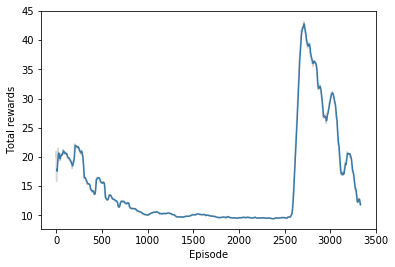

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

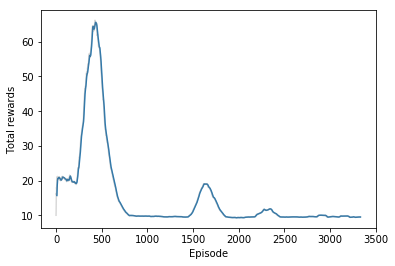

In [24]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

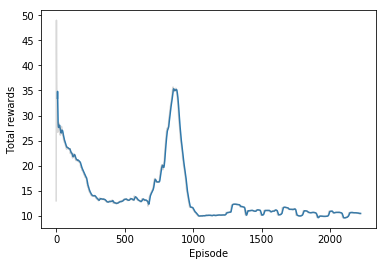

In [26]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

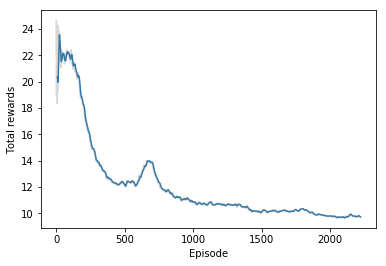

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

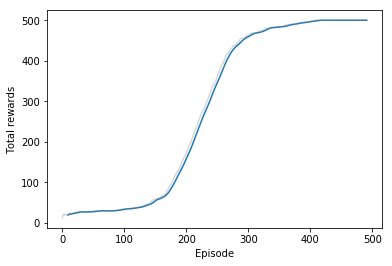

In [62]:
# eps, arr = np.array(episode_rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

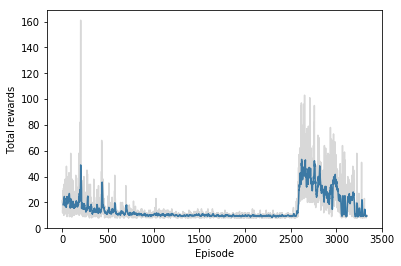

In [17]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

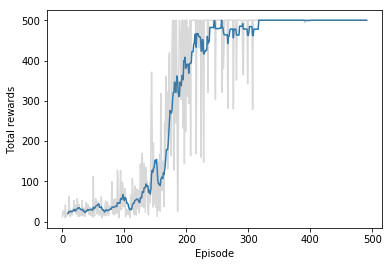

In [63]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

In [19]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.